<html> <h1 style="font-style:bold; color:blue;"> Machine Learning in Finance </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-10 - Wait-Attention (Flat-Trend) - Gold - LSTM </h1> </html>

## Gold  - Period: 01/01/2024 - 30/06/2024
5-minutes time-frame
     
### Predictions of Flat-Trend
- Early-Stopping
- Loss function: BinaryCrossentropy
- Metrics: F1, Precision, Recall, Accuracy

### length of analysed history (sliding window)- 50 raws ago

#### dataset: 35232 rows (5-minutes)
#### use part of the dataset: 12000 rows, which is around 2 months
#### train / test = 90 /10

In [1]:
# epoch = 20
# patience = 5
# take-profit = $10
# hours = 4


________________________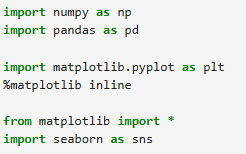

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline

from matplotlib import *
import seaborn as sns

____________________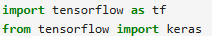

In [3]:
import tensorflow as tf 
from tensorflow import keras

__________________

In [5]:
print(tf.__version__)

2.18.0


_______________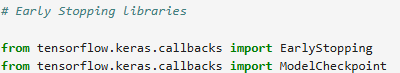

In [7]:
# Early Stopping Libraries

from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint

_____________

In [9]:
np.random.seed(19)

____________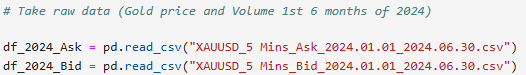

In [13]:
# Take raw data (Gold price and Volume 1st 6 months of 2024)

df_2024_Ask = pd.read_csv("XAUUSD_5 Mins_Ask_2024.01.01_2024.06.30.csv") 
df_2024_Bid = pd.read_csv("XAUUSD_5 Mins_Bid_2024.01.01_2024.06.30.csv")

______________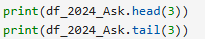

In [15]:
print(df_2024_Ask.head(3))
print(df_2024_Ask.tail(3))

            Time (UTC)      Open      High       Low     Close  Volume 
0  2024.01.01 23:00:00  2064.562  2067.475  2064.075  2065.686  0.11843
1  2024.01.01 23:05:00  2065.616  2065.839  2064.476  2064.902  0.06906
2  2024.01.01 23:10:00  2064.902  2066.825  2064.752  2066.105  0.04203
                Time (UTC)      Open      High       Low     Close  Volume 
35229  2024.06.30 23:45:00  2326.026  2326.315  2325.875  2325.945  0.02538
35230  2024.06.30 23:50:00  2325.945  2325.945  2325.555  2325.795  0.02880
35231  2024.06.30 23:55:00  2325.825  2325.835  2325.066  2325.245  0.07257


____________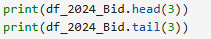

In [17]:
print(df_2024_Bid.head(3))
print(df_2024_Bid.tail(3))

            Time (UTC)      Open      High       Low     Close  Volume 
0  2024.01.01 23:00:00  2062.598  2066.595  2062.405  2065.214  0.12012
1  2024.01.01 23:05:00  2065.185  2065.194  2063.851  2064.455  0.06508
2  2024.01.01 23:10:00  2064.424  2066.365  2064.395  2065.734  0.03945
                Time (UTC)      Open      High       Low     Close  Volume 
35229  2024.06.30 23:45:00  2325.645  2325.905  2325.465  2325.525  0.06891
35230  2024.06.30 23:50:00  2325.515  2325.525  2325.125  2325.385  0.09813
35231  2024.06.30 23:55:00  2325.438  2325.438  2324.625  2324.825  0.07851


<html> <h3 style="font-style:italic; color:blue;"> Merge DataFrame </h3> </html>

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [25]:
#(!! DO ONLY ONCE)

data = df_2024_Bid.merge(df_2024_Ask, left_on='Time (UTC)', right_on='Time (UTC)', how='outer')

data

Time (UTC)    Open_x    High_x     Low_x   Close_x  Volume _x  \
0      2024.01.01 23:00:00  2062.598  2066.595  2062.405  2065.214    0.12012   
1      2024.01.01 23:05:00  2065.185  2065.194  2063.851  2064.455    0.06508   
2      2024.01.01 23:10:00  2064.424  2066.365  2064.395  2065.734    0.03945   
3      2024.01.01 23:15:00  2065.715  2066.075  2065.055  2065.585    0.04386   
4      2024.01.01 23:20:00  2065.585  2065.815  2065.295  2065.555    0.03171   
...                    ...       ...       ...       ...       ...        ...   
35227  2024.06.30 23:35:00  2325.005  2326.035  2324.905  2325.625    0.07389   
35228  2024.06.30 23:40:00  2325.625  2325.755  2325.165  2325.575    0.06771   
35229  2024.06.30 23:45:00  2325.645  2325.905  2325.465  2325.525    0.06891   
35230  2024.06.30 23:50:00  2325.515  2325.525  2325.125  2325.385    0.09813   
35231  2024.06.30 23:55:00  2325.438  2325.438  2324.625  2324.825    0.07851   

         Open_y    High_y     Low_y   Close_y  Volume _y  
0      2064.562  2067.475  2064.075  2065.686    0.11843  
1      2065.616  2065.839  2064.476  2064.902    0.06906  
2      2064.902  2066.825  2064.752  2066.105    0.04203  
3      2066.105  2066.525  2065.415  2065.986    0.03201  
4      2065.992  2066.242  2065.645  2065.855    0.03309  
...         ...       ...       ...       ...        ...  
35227  2325.425  2326.455  2325.345  2326.065    0.07116  
35228  2326.045  2326.202  2325.595  2325.965    0.04635  
35229  2326.026  2326.315  2325.875  2325.945    0.02538  
35230  2325.945  2325.945  2325.555  2325.795    0.02880  
35231  2325.825  2325.835  2325.066  2325.245    0.07257  

[35232 rows x 11 columns]

In [21]:
data = df_2024_Bid.merge(df_2024_Ask, left_on='Time (UTC)', right_on='Time (UTC)', how='outer')

data

Time (UTC)    Open_x    High_x     Low_x   Close_x  Volume _x  \
0      2024.01.01 23:00:00  2062.598  2066.595  2062.405  2065.214    0.12012   
1      2024.01.01 23:05:00  2065.185  2065.194  2063.851  2064.455    0.06508   
2      2024.01.01 23:10:00  2064.424  2066.365  2064.395  2065.734    0.03945   
3      2024.01.01 23:15:00  2065.715  2066.075  2065.055  2065.585    0.04386   
4      2024.01.01 23:20:00  2065.585  2065.815  2065.295  2065.555    0.03171   
...                    ...       ...       ...       ...       ...        ...   
35227  2024.06.30 23:35:00  2325.005  2326.035  2324.905  2325.625    0.07389   
35228  2024.06.30 23:40:00  2325.625  2325.755  2325.165  2325.575    0.06771   
35229  2024.06.30 23:45:00  2325.645  2325.905  2325.465  2325.525    0.06891   
35230  2024.06.30 23:50:00  2325.515  2325.525  2325.125  2325.385    0.09813   
35231  2024.06.30 23:55:00  2325.438  2325.438  2324.625  2324.825    0.07851   

         Open_y    High_y     Low_y   Close_y  Volume _y  
0      2064.562  2067.475  2064.075  2065.686    0.11843  
1      2065.616  2065.839  2064.476  2064.902    0.06906  
2      2064.902  2066.825  2064.752  2066.105    0.04203  
3      2066.105  2066.525  2065.415  2065.986    0.03201  
4      2065.992  2066.242  2065.645  2065.855    0.03309  
...         ...       ...       ...       ...        ...  
35227  2325.425  2326.455  2325.345  2326.065    0.07116  
35228  2326.045  2326.202  2325.595  2325.965    0.04635  
35229  2326.026  2326.315  2325.875  2325.945    0.02538  
35230  2325.945  2325.945  2325.555  2325.795    0.02880  
35231  2325.825  2325.835  2325.066  2325.245    0.07257  

[35232 rows x 11 columns]

____________________

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35232 entries, 0 to 35231
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time (UTC)  35232 non-null  object 
 1   Open_x      35232 non-null  float64
 2   High_x      35232 non-null  float64
 3   Low_x       35232 non-null  float64
 4   Close_x     35232 non-null  float64
 5   Volume _x   35232 non-null  float64
 6   Open_y      35232 non-null  float64
 7   High_y      35232 non-null  float64
 8   Low_y       35232 non-null  float64
 9   Close_y     35232 non-null  float64
 10  Volume _y   35232 non-null  float64
dtypes: float64(10), object(1)
memory usage: 3.0+ MB


In [28]:
# No NaN elements !

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [29]:
# rename columns

data.columns = ['Local time', 'Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 
                   'Open_Ask', 'High_Ask', 'Low_Ask', 'Close_Ask', 'Volume_Ask']

In [25]:
#rename columns
data.columns = ['Local time', 'Open Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 
                 'Open_Ask', 'High_Ask', 'Low_Ask', 'Close_Ask', 'Volume_Ask']

__________________

In [27]:
data.head(3)

Local time  Open Bid  High_Bid   Low_Bid  Close_Bid  Volume_Bid  \
0  2024.01.01 23:00:00  2062.598  2066.595  2062.405   2065.214     0.12012   
1  2024.01.01 23:05:00  2065.185  2065.194  2063.851   2064.455     0.06508   
2  2024.01.01 23:10:00  2064.424  2066.365  2064.395   2065.734     0.03945   

   Open_Ask  High_Ask   Low_Ask  Close_Ask  Volume_Ask  
0  2064.562  2067.475  2064.075   2065.686     0.11843  
1  2065.616  2065.839  2064.476   2064.902     0.06906  
2  2064.902  2066.825  2064.752   2066.105     0.04203

#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

In [37]:
# Delta of trading volumes (as well as the modulus of this delta) between Ask 
# and Bid volumes are added as additional parameters

data["Volume_Delta"] = data["Volume_Ask"] - data["Volume_Bid"]
data["Volume_Delta_abs"] = (data["Volume_Ask"] - data["Volume_Bid"]).abs()

In [ ]:
data["Open_Delta"] = data["Open_Ask"]  - data["Open_Bid"]
data["High_Delta"] = data["High_Ask"]  - data["High_Bid"]
data["Low_Delta"]  = data["Low_Ask"]   - data["Low_Bid"]
data["Close_Delta"]= data["Close_Ask"] - data["Close_Bid"]

_________________

In [41]:
data.describe()

Open Bid      High_Bid       Low_Bid     Close_Bid    Volume_Bid  \
count  35232.000000  35232.000000  35232.000000  35232.000000  35232.000000   
mean    2205.889710   2206.645921   2205.128739   2205.897065      0.152156   
std      142.978742    143.165839    142.780793    142.978152      0.159003   
min     1985.635000   1986.595000   1984.088000   1985.625000      0.000000   
25%     2035.855000   2036.333250   2035.385000   2035.855000      0.046255   
50%     2255.281500   2256.425000   2254.270000   2255.301500      0.098350   
75%     2333.475000   2334.292250   2332.639750   2333.477500      0.199250   
max     2449.735000   2449.985000   2447.555000   2449.758000      1.485490   

           Open_Ask      High_Ask       Low_Ask     Close_Ask    Volume_Ask  \
count  35232.000000  35232.000000  35232.000000  35232.000000  35232.000000   
mean    2206.249356   2207.005264   2205.487844   2206.256846      0.152062   
std      143.005802    143.192352    142.808660    143.005909      0.156439   
min     1985.915000   1986.945000   1984.475000   1985.915000      0.000000   
25%     2036.195000   2036.675000   2035.722000   2036.195000      0.049140   
50%     2255.650000   2256.758500   2254.608500   2255.660000      0.101700   
75%     2333.878250   2334.685250   2333.005000   2333.886750      0.196412   
max     2450.185000   2450.325000   2447.966000   2450.165000      2.842680   

       Volume_Delta  Volume_Delta_abs  
count  35232.000000      35232.000000  
mean      -0.000094          0.085480  
std        0.130376          0.098443  
min       -1.064400          0.000000  
25%       -0.051012          0.017700  
50%        0.001105          0.052920  
75%        0.054670          0.118320  
max        2.703590          2.703590

______________

In [45]:
data.shape

(35232, 13)

_______________

In [47]:
data.head(3)

Local time  Open Bid  High_Bid   Low_Bid  Close_Bid  Volume_Bid  \
0  2024.01.01 23:00:00  2062.598  2066.595  2062.405   2065.214     0.12012   
1  2024.01.01 23:05:00  2065.185  2065.194  2063.851   2064.455     0.06508   
2  2024.01.01 23:10:00  2064.424  2066.365  2064.395   2065.734     0.03945   

   Open_Ask  High_Ask   Low_Ask  Close_Ask  Volume_Ask  Volume_Delta  \
0  2064.562  2067.475  2064.075   2065.686     0.11843      -0.00169   
1  2065.616  2065.839  2064.476   2064.902     0.06906       0.00398   
2  2064.902  2066.825  2064.752   2066.105     0.04203       0.00258   

   Volume_Delta_abs  
0           0.00169  
1           0.00398  
2           0.00258

<html> <h3 style="font-style:italic; color:blue;"> Date transformation </h3> </html>

_____________________

In [49]:
import datetime

______________________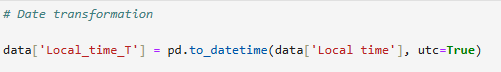

In [51]:
data['Local_time_T'] =pd.to_datetime(data['Local time'], utc=True)

_____________

In [55]:
data=data.drop(['Local time'],axis=1)

________________

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35232 entries, 0 to 35231
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   Open Bid          35232 non-null  float64            
 1   High_Bid          35232 non-null  float64            
 2   Low_Bid           35232 non-null  float64            
 3   Close_Bid         35232 non-null  float64            
 4   Volume_Bid        35232 non-null  float64            
 5   Open_Ask          35232 non-null  float64            
 6   High_Ask          35232 non-null  float64            
 7   Low_Ask           35232 non-null  float64            
 8   Close_Ask         35232 non-null  float64            
 9   Volume_Ask        35232 non-null  float64            
 10  Volume_Delta      35232 non-null  float64            
 11  Volume_Delta_abs  35232 non-null  float64            
 12  Local_time_T      35232 non-null  datetime64[ns, UTC]
dtypes

<html> <h3 style="font-style:italic; color:blue;"> Data Visualisation </h3> </html>

#### Now just press 'CTRL' and 'ENTER' keys on the next 3 cells.

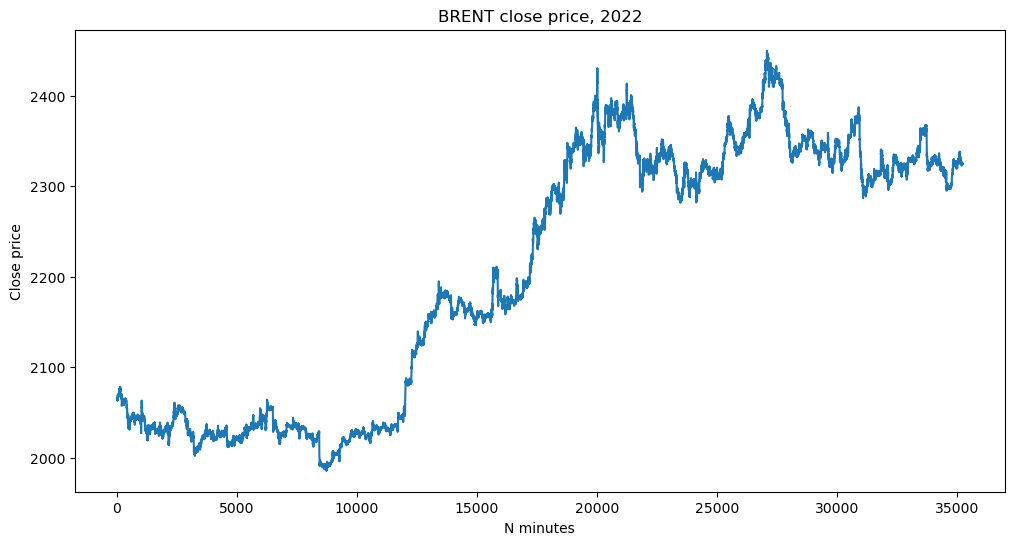

In [59]:
plt.figure(figsize=(12,6))
plt.plot(data['Close_Bid'])
plt.title('BRENT close price, 2022')
plt.xlabel('N minutes')
plt.ylabel('Close price')
plt.show()

<Figure size 1200x500 with 0 Axes>

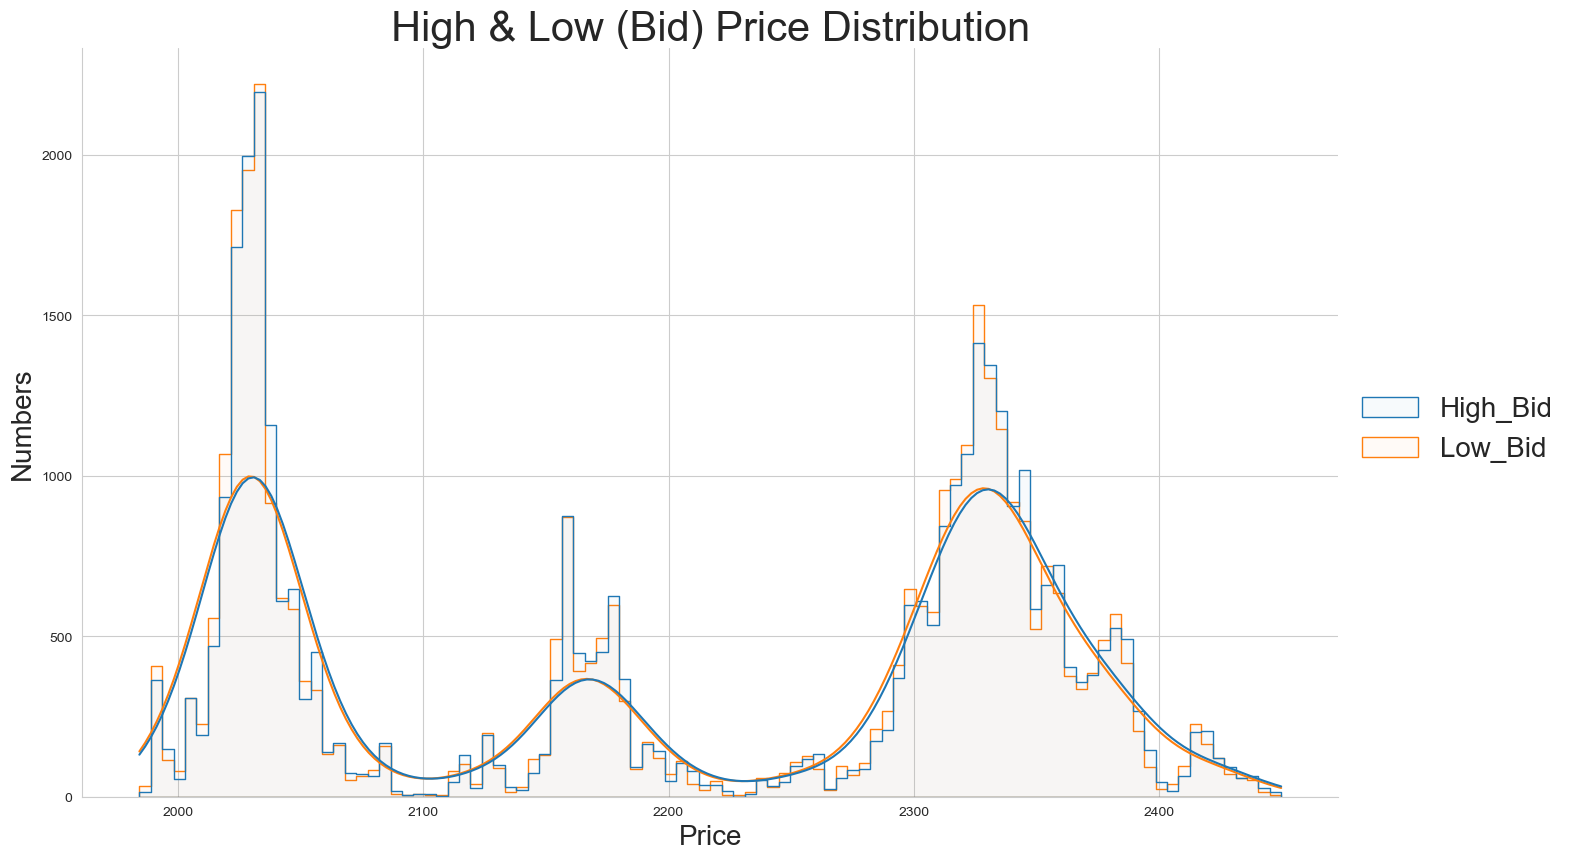

In [61]:
fig = plt.figure(figsize=(12, 5))
plt.rc('axes', titlesize= 30 ) 
sns.set_style('whitegrid')
sns.set_context(rc={'legend.fontsize': 20.0}) 

sns.displot( 
            data[['High_Bid', 'Low_Bid']],
            height=8,
            aspect=1.7,
            #hue="species", 
            kde=True,
            element="step",
            bins=100,
            alpha=0.03,          
                        
)

plt.title('High & Low (Bid) Price Distribution')
plt.xlabel('Price', size= 20)
#plt.ylabel('count (%)')
plt.ylabel('Numbers', size= 20)
plt.show();

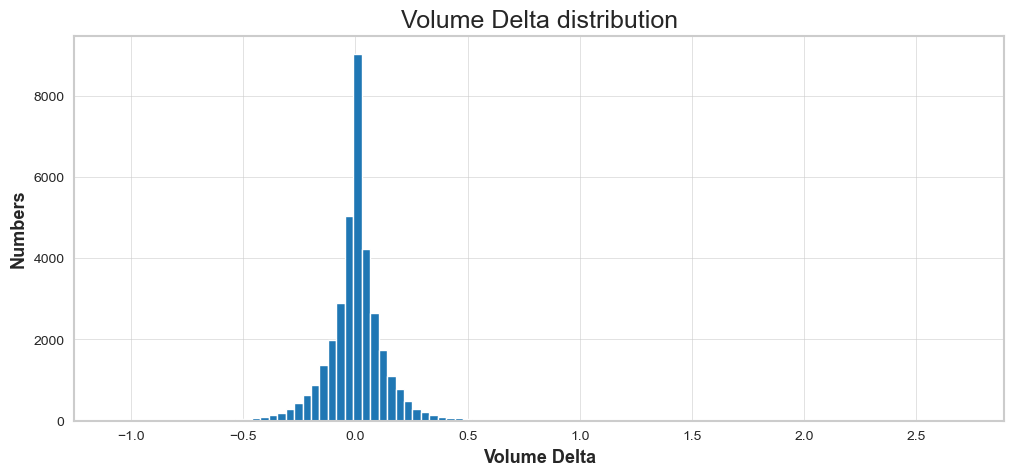

In [86]:
plt.figure(num=1,figsize=(12,5))
plt.hist(data['Volume_Delta'],bins=100)
plt.title('Volume Delta distribution',size=18)
plt.ylabel('Numbers',size=13)
plt.xlabel('Volume Delta',size=13);

In [88]:
# Distribution has mostly positive values
# So Volume_Ask is usually greater than Volume_Bid,
# This corresponds to the upward trend in Gold in the first 6 months of 2024

<html> <h3 style="font-style:italic; color:blue;"> Indicate starts of days and weeks </h3> </html>

_____________________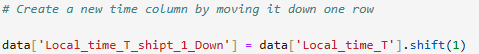

In [64]:
# Create a new time column by moving it down one row
data['Local_time_T_shipt_1_Down'] = data['Local_time_T'].shift(1)

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [68]:
# calculate the time interval with the previous raw

data["Local_time_T_Delta"] = data["Local_time_T"] - data["Local_time_T_shipt_1_Down"]

_____________________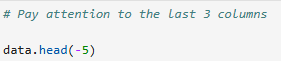

In [70]:
data.head(-5)

Open Bid  High_Bid   Low_Bid  Close_Bid  Volume_Bid  Open_Ask  \
0      2062.598  2066.595  2062.405   2065.214     0.12012  2064.562   
1      2065.185  2065.194  2063.851   2064.455     0.06508  2065.616   
2      2064.424  2066.365  2064.395   2065.734     0.03945  2064.902   
3      2065.715  2066.075  2065.055   2065.585     0.04386  2066.105   
4      2065.585  2065.815  2065.295   2065.555     0.03171  2065.992   
...         ...       ...       ...        ...         ...       ...   
35222  2324.145  2325.445  2324.145   2325.395     0.04935  2324.635   
35223  2325.395  2325.465  2324.955   2325.005     0.04422  2325.815   
35224  2324.945  2325.135  2324.655   2325.005     0.01317  2325.355   
35225  2324.975  2325.115  2324.835   2325.055     0.01080  2325.385   
35226  2325.055  2325.245  2324.725   2324.995     0.04497  2325.465   

       High_Ask   Low_Ask  Close_Ask  Volume_Ask  Volume_Delta  \
0      2067.475  2064.075   2065.686     0.11843      -0.00169   
1      2065.839  2064.476   2064.902     0.06906       0.00398   
2      2066.825  2064.752   2066.105     0.04203       0.00258   
3      2066.525  2065.415   2065.986     0.03201      -0.01185   
4      2066.242  2065.645   2065.855     0.03309       0.00138   
...         ...       ...        ...         ...           ...   
35222  2325.865  2324.635   2325.835     0.05331       0.00396   
35223  2325.905  2325.355   2325.425     0.02031      -0.02391   
35224  2325.525  2325.095   2325.415     0.01059      -0.00258   
35225  2325.525  2325.245   2325.475     0.00846      -0.00234   
35226  2325.635  2325.165   2325.425     0.01773      -0.02724   

       Volume_Delta_abs              Local_time_T Local_time_T_shipt_1_Down  \
0               0.00169 2024-01-01 23:00:00+00:00                       NaT   
1               0.00398 2024-01-01 23:05:00+00:00 2024-01-01 23:00:00+00:00   
2               0.00258 2024-01-01 23:10:00+00:00 2024-01-01 23:05:00+00:00   
3               0.01185 2024-01-01 23:15:00+00:00 2024-01-01 23:10:00+00:00   
4               0.00138 2024-01-01 23:20:00+00:00 2024-01-01 23:15:00+00:00   
...                 ...                       ...                       ...   
35222           0.00396 2024-06-30 23:10:00+00:00 2024-06-30 23:05:00+00:00   
35223           0.02391 2024-06-30 23:15:00+00:00 2024-06-30 23:10:00+00:00   
35224           0.00258 2024-06-30 23:20:00+00:00 2024-06-30 23:15:00+00:00   
35225           0.00234 2024-06-30 23:25:00+00:00 2024-06-30 23:20:00+00:00   
35226           0.02724 2024-06-30 23:30:00+00:00 2024-06-30 23:25:00+00:00   

      Local_time_T_Delta  
0                    NaT  
1        0 days 00:05:00  
2        0 days 00:05:00  
3        0 days 00:05:00  
4        0 days 00:05:00  
...                  ...  
35222    0 days 00:05:00  
35223    0 days 00:05:00  
35224    0 days 00:05:00  
35225    0 days 00:05:00  
35226    0 days 00:05:00  

[35227 rows x 15 columns]

______________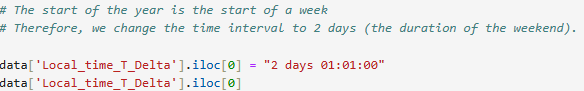

In [74]:
data['Local_time_T_Delta'].iloc[0] = "2 days 01:01:00"
data['Local_time_T_Delta'].iloc[0]

C:\Users\hp\AppData\Local\Temp\ipykernel_11080\1040467289.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Local_time_T_Delta'].iloc[0] = "2 days 01:01:00"
C:\Users\hp\AppData\Local\Temp\ipykernel_11080\1040467289.py:1: SettingWithC

Timedelta('2 days 01:01:00')

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [78]:
# find intervals which are longer than 5 minutes

data[['Local_time_T_Delta']][data["Local_time_T_Delta"] > '0 days 00:05:00'].value_counts(sort=False)

Local_time_T_Delta
0 days 01:05:00       98
0 days 03:35:00        4
2 days 00:05:00        1
2 days 01:01:00        1
2 days 01:05:00       24
3 days 01:05:00        1
Name: count, dtype: int64

In [106]:
# We found the duration of night intervals when there is no trading in Gold.
# Total such intervals - 125, which is equal to the number of trading days during 6 first months of 2024

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [90]:
# create a new DataFrame with the beginning of the new days

new_day = data[['Local_time_T_Delta']][data["Local_time_T_Delta"] > '0 days 00:05:00']

_________________________

In [92]:
new_day['Local_time_T_Delta'].value_counts(sort=False)

Local_time_T_Delta
2 days 01:01:00     1
0 days 01:05:00    98
2 days 01:05:00    24
0 days 03:35:00     4
2 days 00:05:00     1
3 days 01:05:00     1
Name: count, dtype: int64

#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

In [94]:
# find intervals which are longer than 1 day

data[['Local_time_T_Delta']][data['Local_time_T_Delta'] > '1 days 00:00:00'].value_counts(sort=False)

Local_time_T_Delta
2 days 00:05:00        1
2 days 01:01:00        1
2 days 01:05:00       24
3 days 01:05:00        1
Name: count, dtype: int64

In [114]:
# We found the weekend duration when there is no trading in Gold.
# Total such intervals - 27, which is equal to the number of weekends during 6 first months of 2024

In [96]:
# create a new DataFrame with the beginning of the new weeks

new_week = data[data["Local_time_T_Delta"] > '1 days 00:00:00']

_______________________

In [100]:
new_week["Local_time_T_Delta"].value_counts(sort=False)

Local_time_T_Delta
2 days 01:01:00     1
2 days 01:05:00    24
2 days 00:05:00     1
3 days 01:05:00     1
Name: count, dtype: int64

________________________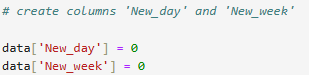

In [102]:
data['New_day'] = 0
data['New_week'] = 0

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [108]:
# Fill in "1" when the new day starts

data.loc[data["Local_time_T_Delta"] > '0 days 00:05:00', 'New_day'] = 1

_______________________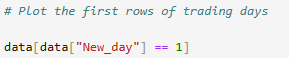

In [110]:
data[data["New_day"] ==1]

Open Bid  High_Bid   Low_Bid  Close_Bid  Volume_Bid  Open_Ask  \
0      2062.598  2066.595  2062.405   2065.214     0.12012  2064.562   
276    2058.018  2059.134  2058.018   2058.758     0.04366  2059.772   
552    2041.895  2042.425  2041.398   2042.044     0.09643  2042.452   
828    2043.218  2043.685  2042.774   2042.864     0.03565  2044.812   
1104   2044.385  2045.005  2042.825   2044.494     0.16514  2046.355   
...         ...       ...       ...        ...         ...       ...   
34104  2333.205  2334.395  2333.205   2333.748     0.07701  2335.000   
34380  2319.575  2319.935  2318.705   2319.925     0.04851  2320.165   
34656  2298.098  2299.055  2297.898   2298.694     0.07182  2299.492   
34932  2327.108  2327.915  2326.875   2326.905     0.02414  2328.992   
35208  2326.315  2326.775  2322.505   2322.905     0.08900  2327.765   

       High_Ask   Low_Ask  Close_Ask  Volume_Ask  Volume_Delta  \
0      2067.475  2064.075   2065.686     0.11843      -0.00169   
276    2059.882  2058.952   2059.292     0.03770      -0.00596   
552    2043.075  2042.015   2042.532     0.10547       0.00904   
828    2045.092  2043.302   2043.302     0.02107      -0.01458   
1104   2046.445  2043.702   2044.966     0.13458      -0.03056   
...         ...       ...        ...         ...           ...   
34104  2335.000  2333.975   2334.245     0.03176      -0.04525   
34380  2320.655  2319.365   2320.375     0.06285       0.01434   
34656  2299.725  2298.736   2299.216     0.07026      -0.00156   
34932  2328.992  2327.295   2327.315     0.04502       0.02088   
35208  2327.915  2323.145   2323.355     0.12398       0.03498   

       Volume_Delta_abs              Local_time_T Local_time_T_shipt_1_Down  \
0               0.00169 2024-01-01 23:00:00+00:00                       NaT   
276             0.00596 2024-01-02 23:00:00+00:00 2024-01-02 21:55:00+00:00   
552             0.00904 2024-01-03 23:00:00+00:00 2024-01-03 21:55:00+00:00   
828             0.01458 2024-01-04 23:00:00+00:00 2024-01-04 21:55:00+00:00   
1104            0.03056 2024-01-07 23:00:00+00:00 2024-01-05 21:55:00+00:00   
...                 ...                       ...                       ...   
34104           0.04525 2024-06-24 22:00:00+00:00 2024-06-24 20:55:00+00:00   
34380           0.01434 2024-06-25 22:00:00+00:00 2024-06-25 20:55:00+00:00   
34656           0.00156 2024-06-26 22:00:00+00:00 2024-06-26 20:55:00+00:00   
34932           0.02088 2024-06-27 22:00:00+00:00 2024-06-27 20:55:00+00:00   
35208           0.03498 2024-06-30 22:00:00+00:00 2024-06-28 20:55:00+00:00   

      Local_time_T_Delta  New_day  New_week  
0        2 days 01:01:00        1         0  
276      0 days 01:05:00        1         0  
552      0 days 01:05:00        1         0  
828      0 days 01:05:00        1         0  
1104     2 days 01:05:00        1         0  
...                  ...      ...       ...  
34104    0 days 01:05:00        1         0  
34380    0 days 01:05:00        1         0  
34656    0 days 01:05:00        1         0  
34932    0 days 01:05:00        1         0  
35208    2 days 01:05:00        1         0  

[129 rows x 17 columns]

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [114]:
# Fill in "1" when the new week starts

data.loc[data["Local_time_T_Delta"] > '1 days 00:00:00', 'New_week'] = 1

____________________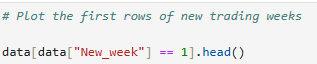

In [116]:
data[data["New_day"] ==1].head()

Open Bid  High_Bid   Low_Bid  Close_Bid  Volume_Bid  Open_Ask  High_Ask  \
0     2062.598  2066.595  2062.405   2065.214     0.12012  2064.562  2067.475   
276   2058.018  2059.134  2058.018   2058.758     0.04366  2059.772  2059.882   
552   2041.895  2042.425  2041.398   2042.044     0.09643  2042.452  2043.075   
828   2043.218  2043.685  2042.774   2042.864     0.03565  2044.812  2045.092   
1104  2044.385  2045.005  2042.825   2044.494     0.16514  2046.355  2046.445   

       Low_Ask  Close_Ask  Volume_Ask  Volume_Delta  Volume_Delta_abs  \
0     2064.075   2065.686     0.11843      -0.00169           0.00169   
276   2058.952   2059.292     0.03770      -0.00596           0.00596   
552   2042.015   2042.532     0.10547       0.00904           0.00904   
828   2043.302   2043.302     0.02107      -0.01458           0.01458   
1104  2043.702   2044.966     0.13458      -0.03056           0.03056   

                  Local_time_T Local_time_T_shipt_1_Down Local_time_T_Delta  \
0    2024-01-01 23:00:00+00:00                       NaT    2 days 01:01:00   
276  2024-01-02 23:00:00+00:00 2024-01-02 21:55:00+00:00    0 days 01:05:00   
552  2024-01-03 23:00:00+00:00 2024-01-03 21:55:00+00:00    0 days 01:05:00   
828  2024-01-04 23:00:00+00:00 2024-01-04 21:55:00+00:00    0 days 01:05:00   
1104 2024-01-07 23:00:00+00:00 2024-01-05 21:55:00+00:00    2 days 01:05:00   

      New_day  New_week  
0           1         1  
276         1         0  
552         1         0  
828         1         0  
1104        1         1

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [139]:
# drop the columns that are no longer needed, 
# since the time series is regular 
# (each line is the next 5-minutes, except for the marked lines in the New_day and New_week columns

data2 = data.drop(['Local_time_T', 'Local_time_T_shipt_1_Down', 'Local_time_T_Delta'],axis=1)

____________________

In [141]:
data2.head(3)

Open Bid  High_Bid   Low_Bid  Close_Bid  Volume_Bid  Open_Ask  High_Ask  \
0  2062.598  2066.595  2062.405   2065.214     0.12012  2064.562  2067.475   
1  2065.185  2065.194  2063.851   2064.455     0.06508  2065.616  2065.839   
2  2064.424  2066.365  2064.395   2065.734     0.03945  2064.902  2066.825   

    Low_Ask  Close_Ask  Volume_Ask  Volume_Delta  Volume_Delta_abs  New_day  \
0  2064.075   2065.686     0.11843      -0.00169           0.00169        1   
1  2064.476   2064.902     0.06906       0.00398           0.00398        0   
2  2064.752   2066.105     0.04203       0.00258           0.00258        0   

   New_week  
0         1  
1         0  
2         0

______________

In [143]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35232 entries, 0 to 35231
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open Bid          35232 non-null  float64
 1   High_Bid          35232 non-null  float64
 2   Low_Bid           35232 non-null  float64
 3   Close_Bid         35232 non-null  float64
 4   Volume_Bid        35232 non-null  float64
 5   Open_Ask          35232 non-null  float64
 6   High_Ask          35232 non-null  float64
 7   Low_Ask           35232 non-null  float64
 8   Close_Ask         35232 non-null  float64
 9   Volume_Ask        35232 non-null  float64
 10  Volume_Delta      35232 non-null  float64
 11  Volume_Delta_abs  35232 non-null  float64
 12  New_day           35232 non-null  int64  
 13  New_week          35232 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 3.8 MB


____________________

In [145]:
data= []

<html> <h3 style="font-style:italic; color:blue;"> Hourly and Daily Volatility Distribution </h3> </html>


_____________________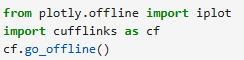

In [149]:
from plotly.offline import iplot
import cufflinks as cf 
cf.go_offline()

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [151]:
# Take 1-hour and 1-day data (Gold price and Volume 1st 6 months of 2024) 

Ask_1h_2024 = pd.read_csv("XAUUSD_Hourly_Ask_2024.01.01_2024.06.30.csv")
Ask_1d_2024 = pd.read_csv("XAUUSD_Daily_Ask_2024.01.01_2024.06.30.csv")

______________

In [153]:
Ask_1h_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time (UTC)  2938 non-null   object 
 1   Open        2938 non-null   float64
 2   High        2938 non-null   float64
 3   Low         2938 non-null   float64
 4   Close       2938 non-null   float64
 5   Volume      2938 non-null   float64
dtypes: float64(5), object(1)
memory usage: 137.8+ KB


__________________

In [155]:
Ask_1d_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time (UTC)  155 non-null    object 
 1   Open        155 non-null    float64
 2   High        155 non-null    float64
 3   Low         155 non-null    float64
 4   Close       155 non-null    float64
 5   Volume      155 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.4+ KB


#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

In [161]:
# Add a column with hourly volatility 

Ask_1h_2024['Volatility'] = Ask_1h_2024['High'] - Ask_1h_2024['Low']

In [167]:
# Add a column with dayly volatility 

Ask_1d_2024['Volatility'] = Ask_1d_2024['High'] - Ask_1d_2024['Low']

__________________________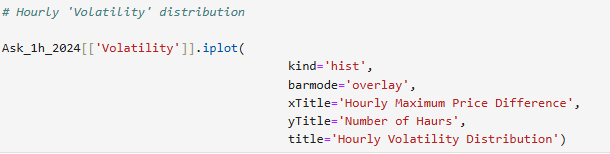

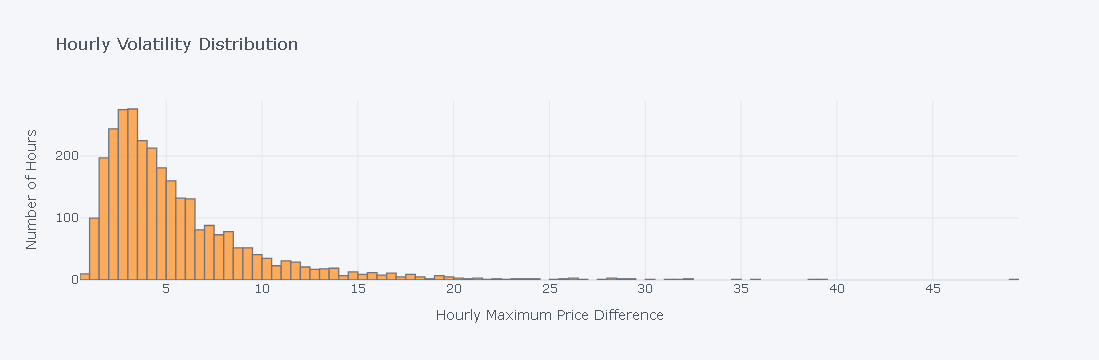

In [176]:
Ask_1h_2024[['Volatility']].iplot(
    kind='hist',
    barmode="overlay",
    xTitle='Hourly Maximum Price Difference', 
    yTitle='Number of Hours',
    title="Hourly Volatility Distribution"
)

____________________

In [178]:
Ask_1h_2024['Volatility'].describe()

count    2938.000000
mean        5.584971
std         4.376151
min         0.700000
25%         2.850000
50%         4.360000
75%         6.865250
max        49.290000
Name: Volatility, dtype: float64

count    2938.000000
mean        5.584971
std         4.376151
min         0.700000
25%         2.850000
50%         4.360000
75%         6.865250
max        49.290000
Name: Volatility, dtype: float64

________________________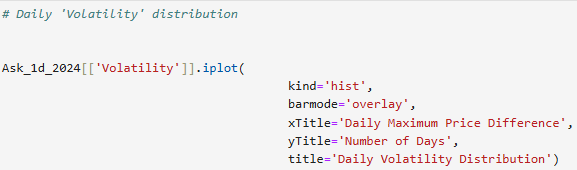

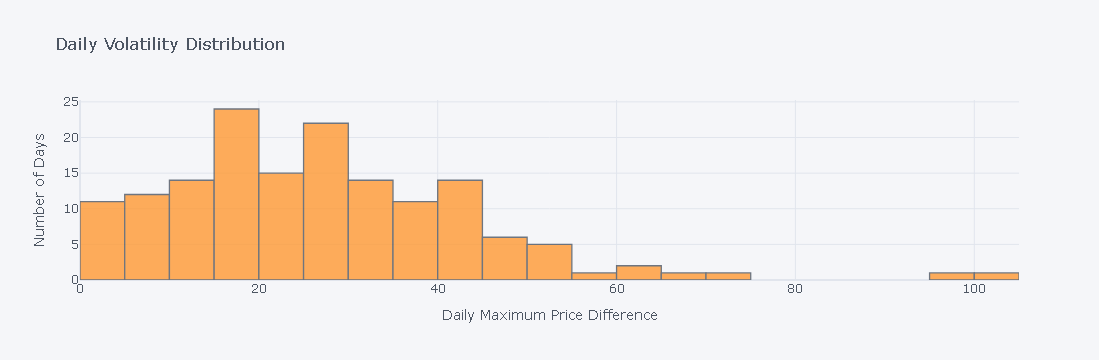

In [182]:
Ask_1d_2024[['Volatility']].iplot(
    kind='hist',
    barmode="overlay",
    xTitle="Daily Maximum Price Difference", 
    yTitle="Number of Days",
    title="Daily Volatility Distribution"
)


_______________________

In [184]:
Ask_1d_2024['Volatility'].describe()

count    155.000000
mean      26.807277
std       16.971237
min        2.066000
25%       15.590000
50%       25.023000
75%       36.279500
max      100.960000
Name: Volatility, dtype: float64

In [158]:
# We will look for rows with potential take-profit = $10


- create 'High_Bid' and 'Low_Ask' 4 hours ahead
- that is, the maximum holding of a position is no more than 4 hours
- 4 hours is 48 of 5-minute intervals


_____________________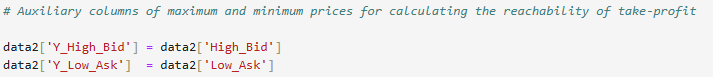

In [188]:
data2['Y_High_Bid'] = data2['High_Bid']
data2['Y_Low_Ask'] = data2['Low_Ask']

________________________

In [190]:
data2.tail(2)

Open Bid  High_Bid   Low_Bid  Close_Bid  Volume_Bid  Open_Ask  \
35230  2325.515  2325.525  2325.125   2325.385     0.09813  2325.945   
35231  2325.438  2325.438  2324.625   2324.825     0.07851  2325.825   

       High_Ask   Low_Ask  Close_Ask  Volume_Ask  Volume_Delta  \
35230  2325.945  2325.555   2325.795     0.02880      -0.06933   
35231  2325.835  2325.066   2325.245     0.07257      -0.00594   

       Volume_Delta_abs  New_day  New_week  Y_High_Bid  Y_Low_Ask  
35230           0.06933        0         0    2325.525   2325.555  
35231           0.00594        0         0    2325.438   2325.066

<html> <h3 style="font-style:italic; color:blue;"> Data Normalisation </h3> </html>

In [172]:
# We do price normalisation simply by dividing all prices by 1000 (for Gold)
# It is not essential that the normalised prices were in the range between [0,1]
# It is more important that the variables were approximately of the same order

In [175]:
# Only applicable to Volumes and Deltas:

# normalisation
# data=(data-data.min())/(data.max()-data.min())

##### Find Max and Min for Prices, Volumes and Deltas

In [178]:
# Max price is Max High_Ask 
# Min price is Min Low_Bid

# Max Volume = Max{Volume_Bid, Volume_Ask}
# Min Volume = 0

# Max_Delta = Max{Open_Delta, High_Delta, Low_Delta, Close_Delta}
# Min_Delta = Min{Open_Delta, High_Delta, Low_Delta, Close_Delta}

#### Now just press 'CTRL' and 'ENTER' keys on the next 19 cells with code.

In [192]:
max_price = (data2['High_Ask']).max()
max_price

2450.325

In [194]:
min_price = data2['Low_Bid'].min()
min_price

1984.088

In [196]:
max_volume = max(max(data2['Volume_Bid']), max(data2['Volume_Ask']))
max_volume

2.84268

In [200]:
max_Delta = max(max(data2['Open_Delta']), max(data2['High_Delta']), max(data2['Low_Delta']), max(data2['Close_Delta']))
max_Delta

KeyError: 'Open_Delta'

In [202]:
max_Delta = round(max_Delta, 3)
max_Delta

NameError: name 'max_Delta' is not defined

In [204]:
min_Delta = min(min(data2['Open_Delta']), min(data2['High_Delta']), min(data2['Low_Delta']), min(data2['Close_Delta']))
min_Delta

KeyError: 'Open_Delta'

In [206]:
min_Delta = round(min_Delta, 3)
min_Delta

NameError: name 'min_Delta' is not defined

In [208]:
max_volume_Delta = data2['Volume_Delta'].max()
max_volume_Delta

2.70359

In [210]:
max_volume_Delta = round(max_volume_Delta, 5)
max_volume_Delta

2.70359

In [198]:
min_volume_Delta = data2['Volume_Delta'].min()
min_volume_Delta

-1.0644

In [212]:
min_volume_Delta = round(min_volume_Delta, 5)
min_volume_Delta

NameError: name 'min_volume_Delta' is not defined

In [214]:
max_volume_Delta_abs = data2['Volume_Delta_abs'].max()
max_volume_Delta_abs

2.70359

In [216]:
max_volume_Delta_abs = round(max_volume_Delta_abs, 5)
max_volume_Delta_abs

2.70359

In [218]:
min_volume_Delta_abs = data2['Volume_Delta_abs'].min()
min_volume_Delta_abs

0.0

In [208]:
# min_volume_Delta_abs = 0
# Therefore, the normalization formula for volume_Delta_abs is simplified

#### Normalise
Run each cell only one time !

In [211]:
# Цены просто делим на 100

data2['Open_Bid']   = data2['Open_Bid']   / 1000
data2['High_Bid']   = data2['High_Bid']   / 1000
data2['Low_Bid']    = data2['Low_Bid']    / 1000
data2['Close_Bid']  = data2['Close_Bid']  / 1000

data2['Open_Ask']   = data2['Open_Ask']   / 1000
data2['High_Ask']   = data2['High_Ask']   / 1000
data2['Low_Ask']    = data2['Low_Ask']    / 1000
data2['Close_Ask']  = data2['Close_Ask']  / 1000

data2['Y_High_Bid'] = data2['Y_High_Bid'] / 1000
data2['Y_Low_Ask']  = data2['Y_Low_Ask']  / 1000



In [220]:
data2['Volume_Ask']  = data2['Volume_Ask'] / max_volume
data2['Volume_Bid']  = data2['Volume_Bid'] / max_volume

In [222]:
data2['Volume_Delta'] = ( data2['Volume_Delta'] - min_volume_Delta ) / (max_volume_Delta-min_volume_Delta)

NameError: name 'min_volume_Delta' is not defined

In [224]:
data2['Volume_Delta_abs']  = data2['Volume_Delta_abs'] / max_volume_Delta_abs

In [219]:
# For the price deltas, the minimum difference is more interesting, therefore we apply inverse normalisation
# data= 1 - (data - data.min()) / (data.max() - data.min()) = (data.max() - data) / (data.max() - data.min())


In [226]:
data2['Open_Delta']  = ( max_Delta - data2['Open_Delta'] )  / (max_Delta-min_Delta)
data2['High_Delta']  = ( max_Delta - data2['High_Delta'] )  / (max_Delta-min_Delta)
data2['Low_Delta']   = ( max_Delta - data2['Low_Delta'] )   / (max_Delta-min_Delta)
data2['Close_Delta'] = ( max_Delta - data2['Close_Delta'] ) / (max_Delta-min_Delta)

NameError: name 'max_Delta' is not defined

________________________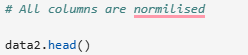

In [228]:
data2.head()

Open Bid  High_Bid   Low_Bid  Close_Bid  Volume_Bid  Open_Ask  High_Ask  \
0  2062.598  2066.595  2062.405   2065.214    0.042256  2064.562  2067.475   
1  2065.185  2065.194  2063.851   2064.455    0.022894  2065.616  2065.839   
2  2064.424  2066.365  2064.395   2065.734    0.013878  2064.902  2066.825   
3  2065.715  2066.075  2065.055   2065.585    0.015429  2066.105  2066.525   
4  2065.585  2065.815  2065.295   2065.555    0.011155  2065.992  2066.242   

    Low_Ask  Close_Ask  Volume_Ask  Volume_Delta  Volume_Delta_abs  New_day  \
0  2064.075   2065.686    0.041661      -0.00169          0.000625        1   
1  2064.476   2064.902    0.024294       0.00398          0.001472        0   
2  2064.752   2066.105    0.014785       0.00258          0.000954        0   
3  2065.415   2065.986    0.011261      -0.01185          0.004383        0   
4  2065.645   2065.855    0.011640       0.00138          0.000510        0   

   New_week  Y_High_Bid  Y_Low_Ask  
0         1    2066.595   2064.075  
1         0    2065.194   2064.476  
2         0    2066.365   2064.752  
3         0    2066.075   2065.415  
4         0    2065.815   2065.645

_______________________

In [230]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35232 entries, 0 to 35231
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open Bid          35232 non-null  float64
 1   High_Bid          35232 non-null  float64
 2   Low_Bid           35232 non-null  float64
 3   Close_Bid         35232 non-null  float64
 4   Volume_Bid        35232 non-null  float64
 5   Open_Ask          35232 non-null  float64
 6   High_Ask          35232 non-null  float64
 7   Low_Ask           35232 non-null  float64
 8   Close_Ask         35232 non-null  float64
 9   Volume_Ask        35232 non-null  float64
 10  Volume_Delta      35232 non-null  float64
 11  Volume_Delta_abs  35232 non-null  float64
 12  New_day           35232 non-null  int64  
 13  New_week          35232 non-null  int64  
 14  Y_High_Bid        35232 non-null  float64
 15  Y_Low_Ask         35232 non-null  float64
dtypes: float64(14), int64(2)
memory usage: 4

#### Now just press 'CTRL' and 'ENTER' keys on the next 4 cells with code.

In [232]:
# Reducing memory size

columns_float =['Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 
                'Open_Ask', 'High_Ask', 'Low_Ask', 'Close_Ask', 'Volume_Ask', 
                'Volume_Delta', 'Volume_Delta_abs', 
                'Open_Delta', 'High_Delta', 'Low_Delta', 'Close_Delta',
                'Y_High_Bid', 'Y_Low_Ask']

columns_integer =['New_day', 'New_week']



In [238]:
for column in columns_float:
    data2[column] = pd.to_numeric(data2[column], downcast='float')

for column in columns_integer:
    data2[column] = pd.to_numeric(data2[column], downcast='integer')
    
data2.info()

KeyError: 'Open_Bid'

In [240]:
data2.shape

(35232, 16)

In [242]:
# inverse normalisation of price deltas, the minimum difference is more interesting

fig = plt.figure(figsize=(12, 5))
plt.rc('axes', titlesize= 30 ) 
sns.set_style('whitegrid')
sns.set_context(rc={'legend.fontsize': 20.0}) 

sns.displot( 
            data2[['Open_Delta', 'Close_Delta']],
            height=8,
            aspect=1.7,
            kde=True,
            element="step",
            bins=100,
            alpha=0.03,          
                        
)

plt.title('Open_Delta & Close_Delta Price Distribution')
plt.xlabel('Price Delta', size= 20)
plt.ylabel('Numbers', size= 20)
plt.show();

KeyError: "None of [Index(['Open_Delta', 'Close_Delta'], dtype='object')] are in the [columns]"

### Date transformation


In [125]:
# We will predict Wait-Attention modes
# Since we have a 5-minute dataset, Then we will shift MiN & MAX prices by 48 rows, which is 4 hours forward

#### Now just press 'CTRL' and 'ENTER' keys on the next 3 cells.

In [244]:
# Rows number

n=data2.shape[0]
n

35232

In [246]:
# Colonms number

p=data2.shape[1]
p

16

In [250]:
# Forward-looking window
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=48)


# create new columns: MIN_Lowest(Low_Ask) and MAX_Highest(High_Bid) prices of DURING NEXT 4 hours
# 48 rows of 5-minute time-frame each

data2['Y_High_Bid_4h'] = data2['Y_High_Bid'].rolling(window=indexer).max()
data2['Y_Low_Ask_4h']  = data2['Y_Low_Ask'].rolling(window=indexer).min()

____________________

In [258]:
data2[['Y_High_Bid_4h', 'Y_Low_Ask_4h']].tail(50)

Y_High_Bid_4h  Y_Low_Ask_4h
35182       2326.775      2323.125
35183       2326.775      2323.125
35184       2326.775      2323.125
35185            NaN           NaN
35186            NaN           NaN
35187            NaN           NaN
35188            NaN           NaN
35189            NaN           NaN
35190            NaN           NaN
35191            NaN           NaN
35192            NaN           NaN
35193            NaN           NaN
35194            NaN           NaN
35195            NaN           NaN
35196            NaN           NaN
35197            NaN           NaN
35198            NaN           NaN
35199            NaN           NaN
35200            NaN           NaN
35201            NaN           NaN
35202            NaN           NaN
35203            NaN           NaN
35204            NaN           NaN
35205            NaN           NaN
35206            NaN           NaN
35207            NaN           NaN
35208            NaN           NaN
35209            NaN           NaN
35210            NaN           NaN
35211            NaN           NaN
35212            NaN           NaN
35213            NaN           NaN
35214            NaN           NaN
35215            NaN           NaN
35216            NaN           NaN
35217            NaN           NaN
35218            NaN           NaN
35219            NaN           NaN
35220            NaN           NaN
35221            NaN           NaN
35222            NaN           NaN
35223            NaN           NaN
35224            NaN           NaN
35225            NaN           NaN
35226            NaN           NaN
35227            NaN           NaN
35228            NaN           NaN
35229            NaN           NaN
35230            NaN           NaN
35231            NaN           NaN

___________________________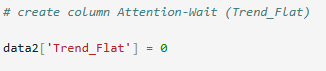

In [260]:
data2['Trend_Flat'] = 0

#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

In [262]:
# Fill in "1s" If the movement (in any direction) within 4 hours is more than $10 (0.01 after the normalisation) 

data2.loc[ (data2["Y_High_Bid_4h"] - data2["Close_Ask"]) >= 0.01, 'Trend_Flat'] = 1
print( data2['Trend_Flat'].sum() )

data2.loc[ (data2["Close_Bid"] - data2["Y_Low_Ask_4h"]) >= 0.01, 'Trend_Flat'] = 1
print( data2['Trend_Flat'].sum() )

34374
35185


In [264]:
print(((data2["Y_High_Bid_4h"] - data2["Close_Ask"])>= 0.01).sum())
print(((data2["Close_Bid"] - data2["Y_Low_Ask_4h"])>= 0.01).sum())

34374
34213


In [138]:
# (5767+5450) = 11217
# 11217-10758 = 459       # rows after which the price moved in both directions by $10 or more

_________________________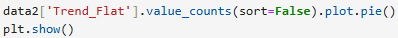

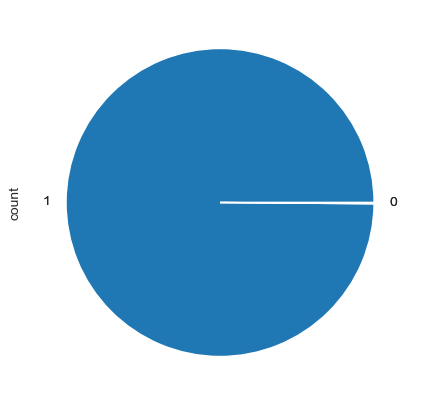

In [270]:
data2['Trend_Flat'].value_counts(sort=False).plot.pie()
plt.show()

In [266]:
data2['Trend_Flat'].value_counts(sort=False).plot.pie()

<Axes: ylabel='count'>

In [273]:
# The dataset is unbalanced

#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

In [272]:
# remove unused columns

data2 = data2.drop(['Y_High_Bid', 'Y_Low_Ask','Y_High_Bid_4h', 'Y_Low_Ask_4h'],axis=1)

In [274]:
# delete the last 48 rows (because we don't have prices for the last 4 hours)

#for i in range(5):
for i in range(48):
        data2.drop(data2.shape[0]-1, axis=0, inplace=True)

_________________________

In [276]:
data2.shape

(35184, 15)

_________________________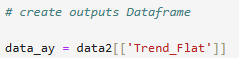

In [282]:
# Inspect column names
print(data2.columns)

# Correct column selection
data_ay = data2[['Trend_Flat']]  # Use the correct name based on the inspection


Index(['Open Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid',
       'Open_Ask', 'High_Ask', 'Low_Ask', 'Close_Ask', 'Volume_Ask',
       'Volume_Delta', 'Volume_Delta_abs', 'New_day', 'New_week',
       'Trend_Flat'],
      dtype='object')


____________________________

In [284]:
data_ay.shape

(35184, 1)

_________________________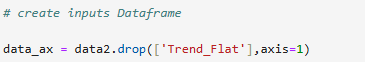

In [290]:
data_ax = data2.drop(['Trend_Flat'],axis=1)

__________________

In [292]:
data_ax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35184 entries, 0 to 35183
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open Bid          35184 non-null  float64
 1   High_Bid          35184 non-null  float64
 2   Low_Bid           35184 non-null  float64
 3   Close_Bid         35184 non-null  float64
 4   Volume_Bid        35184 non-null  float64
 5   Open_Ask          35184 non-null  float64
 6   High_Ask          35184 non-null  float64
 7   Low_Ask           35184 non-null  float64
 8   Close_Ask         35184 non-null  float64
 9   Volume_Ask        35184 non-null  float64
 10  Volume_Delta      35184 non-null  float64
 11  Volume_Delta_abs  35184 non-null  float64
 12  New_day           35184 non-null  int64  
 13  New_week          35184 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 3.8 MB


__________________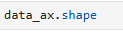

In [294]:
data_ax.shape

(35184, 14)

#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

In [296]:
# Create inputs Numpy

data_a = np.array(data_ax) 

with np.printoptions(precision=4):
    print("data_a:")
    print(data_a[:2,:])  
    print('\n')
    print(data_a[-2:,:]) 

print("numpy size: = ", data_a.shape)
print("type: ", data_a.dtype) 


data_a:
[[ 2.0626e+03  2.0666e+03  2.0624e+03  2.0652e+03  4.2256e-02  2.0646e+03
   2.0675e+03  2.0641e+03  2.0657e+03  4.1661e-02 -1.6900e-03  6.2509e-04
   1.0000e+00  1.0000e+00]
 [ 2.0652e+03  2.0652e+03  2.0639e+03  2.0645e+03  2.2894e-02  2.0656e+03
   2.0658e+03  2.0645e+03  2.0649e+03  2.4294e-02  3.9800e-03  1.4721e-03
   0.0000e+00  0.0000e+00]]


[[2.3258e+03 2.3260e+03 2.3256e+03 2.3259e+03 2.7629e-02 2.3261e+03
  2.3263e+03 2.3259e+03 2.3262e+03 5.3847e-02 7.4530e-02 2.7567e-02
  0.0000e+00 0.0000e+00]
 [2.3259e+03 2.3260e+03 2.3252e+03 2.3257e+03 5.0308e-02 2.3262e+03
  2.3264e+03 2.3256e+03 2.3260e+03 5.5778e-02 1.5550e-02 5.7516e-03
  0.0000e+00 0.0000e+00]]
numpy size: =  (35184, 14)
type:  float64


In [298]:
# Create outputs Numpy

data_y = np.array(data_ay) 

print("data_a:")
print(data_y[:3,:])  
print('\n')
print(data_y[-3:,:]) 

print("numpy size: = ", data_y.shape)
print("type: ", data_y.dtype) 

data_a:
[[1]
 [1]
 [1]]


[[1]
 [1]
 [1]]
numpy size: =  (35184, 1)
type:  int64


_______________________________________

In [300]:
len(data_a)

35184

#### Create the 3D inputs tensor, and 2D outputs matrix

In [ ]:
# Analysis of the entire dataset would take a long time,
# so, please reduce the dataset by about 3 times to 12000 rows

# n_small = 12000 rows (5-minutes), which is around 2 months.

In [304]:
# We need a three-dimensional data tensor: [(n_small-N ), N, 18] and
# one-dimensional array of answers [(n_small-N ), 1] with the High and Low prices DURING the next 5 minutes

# where N=50 is the number of minutes for analysis at each step; those are looking backwards 

# Therefore, we need:
# three-dimensional data tensor of sliced graphs [(n_small - N - 5), N, 18] and
# two-dimensional matrix of answers Y[(n_small - N - 5), 2] 
# with the Trend-Flat indicator, indicating whether take profit will be reached within 4 hours or not

___________________________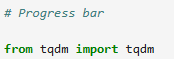

In [302]:
from tqdm import tqdm

#### Now just press 'CTRL' and 'ENTER' keys on the next 4 cells.

In [304]:
# n_small = len(data_y)    

n_small = 12000    # reduce the dataset size

N=50               # sliding window depth

L=n_small-N        # number of sliding window slices
t=data_a.shape[1]  # features number
print('Size of a three-dimensional inputs tensor: ',L,N,t)


Size of a three-dimensional inputs tensor:  11950 50 14


In [306]:
# create imputs zeros 3D tensors with 'float32'

data_b = np.zeros( (L, N, t), dtype= 'float32' ) 

In [310]:
# create a one-dimensional zeros vector of answers

Y = np.zeros((L, 1), dtype= 'float32')  # We will predict Attention - Wait for signals

In [312]:
# fill the imputs 3D tansor (data_b) 
# and the array of answers Y 


print('L = n_small - N = ', n_small-N, L)
for k in tqdm(range(L)):
    data_b[k, :, :] = data_a[k:k+N, :]   
                                          
    Y[k,0] = data_y[k+N-1,0]   # Trend-Flat signal

print(k)                       # index value (for control)
    
print('data_b:', '\n', data_b)
print("Numpy size:        ", data_b.shape, '\n')

print( Y[:5,:])
print( Y[-10:,:])
print(      "Numpy size:         ", Y.shape)

L = n_small - N =  11950 11950


100%|██████████| 11950/11950 [00:00<00:00, 53790.44it/s]

11949
data_b: 
 [[[2.0625979e+03 2.0665950e+03 2.0624050e+03 ... 6.2509481e-04
   1.0000000e+00 1.0000000e+00]
  [2.0651851e+03 2.0651941e+03 2.0638511e+03 ... 1.4721167e-03
   0.0000000e+00 0.0000000e+00]
  [2.0644241e+03 2.0663650e+03 2.0643950e+03 ... 9.5428672e-04
   0.0000000e+00 0.0000000e+00]
  ...
  [2.0673750e+03 2.0677451e+03 2.0672380e+03 ... 2.2551496e-02
   0.0000000e+00 0.0000000e+00]
  [2.0676951e+03 2.0677251e+03 2.0664451e+03 ... 2.1305005e-03
   0.0000000e+00 0.0000000e+00]
  [2.0669951e+03 2.0686050e+03 2.0669580e+03 ... 1.7461967e-02
   0.0000000e+00 0.0000000e+00]]

 [[2.0651851e+03 2.0651941e+03 2.0638511e+03 ... 1.4721167e-03
   0.0000000e+00 0.0000000e+00]
  [2.0644241e+03 2.0663650e+03 2.0643950e+03 ... 9.5428672e-04
   0.0000000e+00 0.0000000e+00]
  [2.0657151e+03 2.0660750e+03 2.0650549e+03 ... 4.3830611e-03
   0.0000000e+00 0.0000000e+00]
  ...
  [2.0676951e+03 2.0677251e+03 2.0664451e+03 ... 2.1305005e-03
   0.0000000e+00 0.0000000e+00]
  [2.0669951e+03 2.0

_______________________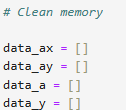

In [314]:
data_ax =[]
data_ay =[]
data_a =[]
data_y =[]

## Train Test Split
- 90% for training and validation
- 10% for testing

___________________________

In [316]:
from sklearn.model_selection import train_test_split

<html> <h3 style="font-style:bold; color:red;"> !!! Use parameters: shuffle = False, stratify = None

Otherwise, the whole time series will be mixed up!
</h3> </html>

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [318]:
# Separate "data_b" and "Y" into X_train, X_test, y_train, y_test i.e. getting training and testing set for the model.

X_train, X_test, y_train, y_test = train_test_split(data_b, Y, test_size=0.1, 
                                                    shuffle = False, stratify = None,
                            # random_state - int for reproducible output across multiple function calls
                                                    random_state=101)

___________________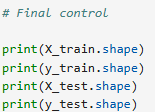

In [330]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split

# Example data as a list of dictionaries (replace with your actual list data)
data_list = [
    {'feature1': 1, 'feature2': 5, 'target': 0},
    {'feature1': 2, 'feature2': 4, 'target': 1},
    {'feature1': 3, 'feature2': 3, 'target': 0},
    {'feature1': 4, 'feature2': 2, 'target': 1},
    {'feature1': 5, 'feature2': 1, 'target': 0}
]

# Convert list to DataFrame
data = pd.DataFrame(data_list)

# Define features (X) and target (y)
X = data.drop('target', axis=1)  # Drop the target column, replace 'target' with the actual column name if needed
y = data['target']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the datasets
print("x_train shape:", x_train.shape)  # Shape of the training features
print("y_train shape:", y_train.shape)  # Shape of the training target
print("x_test shape:", x_test.shape)    # Shape of the testing features
print("y_test shape:", y_test.shape)    # Shape of the testing target

x_train shape: (4, 2)
y_train shape: (4,)
x_test shape: (1, 2)
y_test shape: (1,)


### Training

#### LSTM

_______________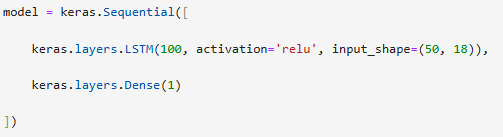

C:\Users\vital\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



___________________________

In [336]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,701 (186.33 KB)

 Trainable params: 47,701 (186.33 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Callbacks

____________________________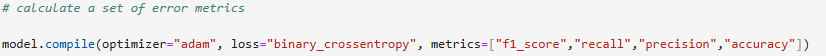

_________________________

________________________

<html> <h4 style="font-style:bold; color:blue;"> If you are using your own laptop without a GPU (Graphics processing unit), 

please change the following parameter in the next cell 
</h4> </html>

<html> <h4 style="font-style:bold; color:red;">
epochs=10
</h4> </html>


__________________________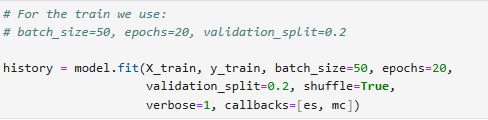

Epoch 1/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7097 - f1_score: 0.4524 - loss: 0.5724 - precision: 0.5167 - recall: 0.1436
Epoch 1: val_loss improved from inf to 0.65773, saving model to best_Trand-Flat_model_LSTM_GOLD.keras
506/506 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.7097 - f1_score: 0.4524 - loss: 0.5723 - precision: 0.5169 - recall: 0.1437 - val_accuracy: 0.6407 - val_f1_score: 0.5408 - val_loss: 0.6577 - val_precision: 0.5158 - val_recall: 0.5000
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7357 - f1_score: 0.4506 - loss: 0.5209 - precision: 0.6001 - recall: 0.2676
Epoch 2: val_loss did not improve from 0.65773
506/506 ━━━━━━━━━━━━━━━━━━━━ 55s 109ms/step - accuracy: 0.7357 - f1_score: 0.4506 - loss: 0.5209 - precision: 0.6001 - recall: 0.2677 - val_accuracy: 0.5043 - val_f1_score: 0.5408 - val_loss: 0.7746 - val_precision: 0.4170 - val_recall: 0.8481
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7383 - f1

______________________________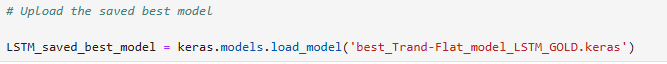

#### Test

_________________________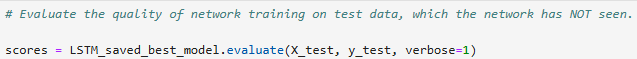

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7252 - f1_score: 0.4785 - loss: 0.5792 - precision: 0.6892 - recall: 0.2052


____________________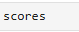

[0.5490404963493347,
 0.42703667283058167,
 0.14989517629146576,
 0.5720000267028809,
 0.7387592196464539]

_______________________

loss function: 0.549040496 


### Visualisation

#### Loss function graphs during training

_________________________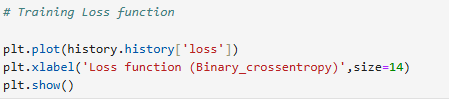

Text(0.5, 0, 'Loss function (Binary_crossentropy)')

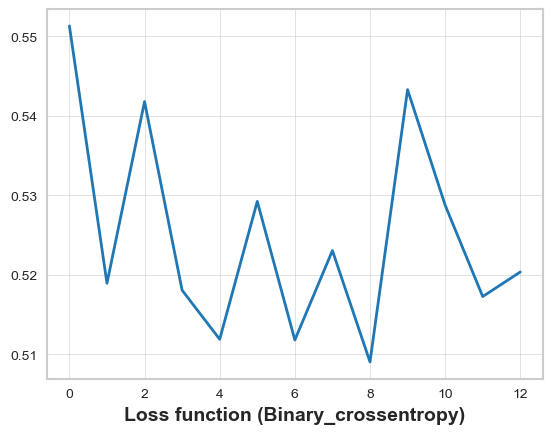

____________________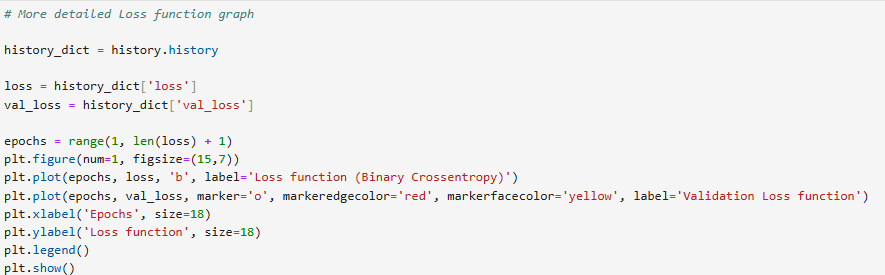

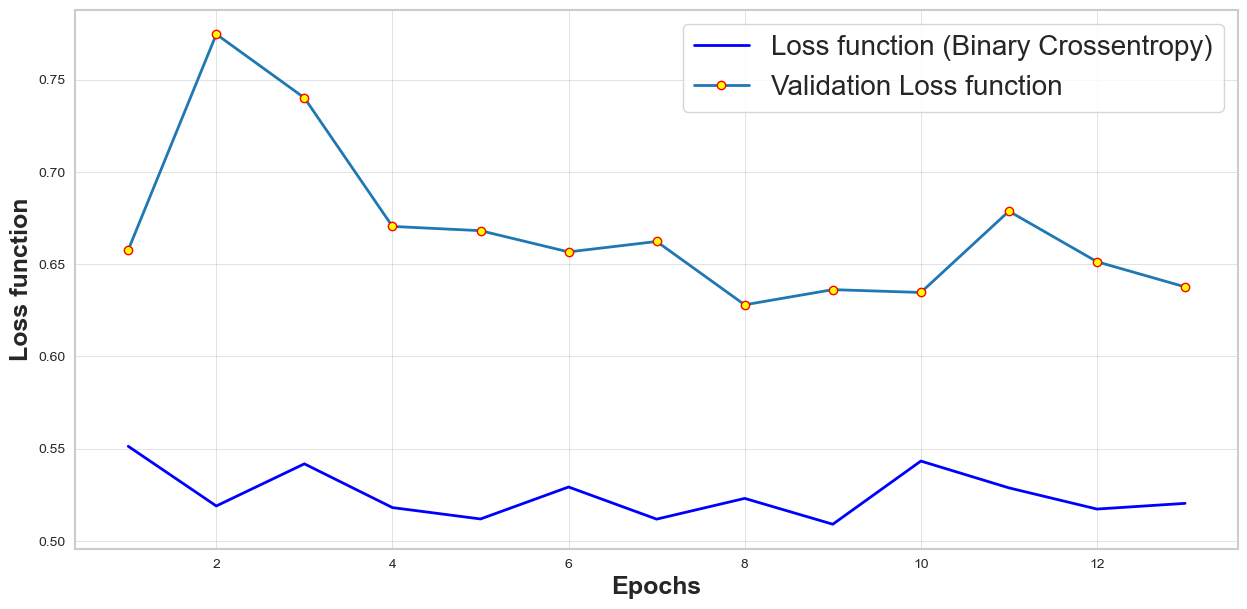

# Lab Logbook Requirement:

<html> <h3 style="font-style:italic; color:blue;">
    
 - Plot 4 graphs:
   1) Precision during training graph
   2) More detailed Precision graph
   3) Training accuracy graph
   4) More detailed Accuracy graph

</h3> </html>

<html> <h3 style="color:red;">
NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.
</h3> </html>

#### Precision during training

Text(0.5, 0, 'precision')

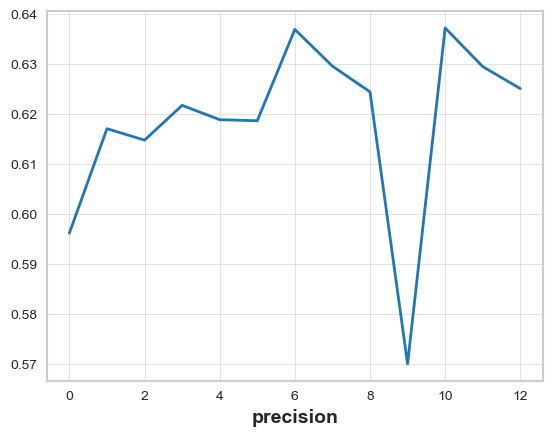

In [373]:
# 
# 
#    Your code of Precision_score
#
#



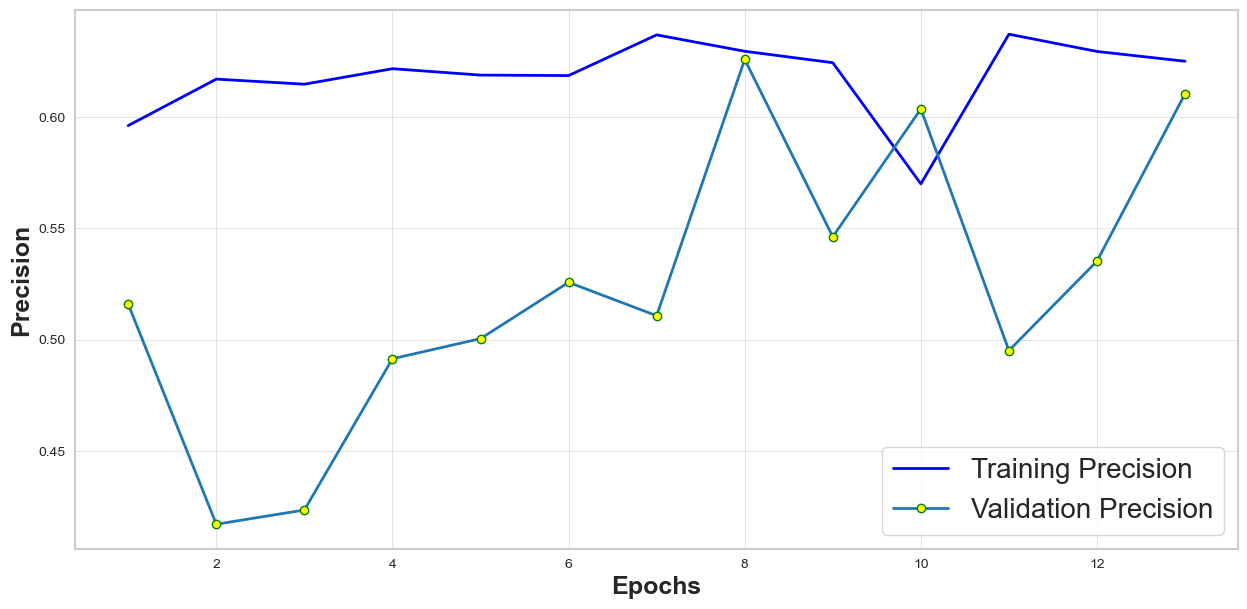

In [376]:
# 
# 
#    Your code of More detailed Precision
#
#



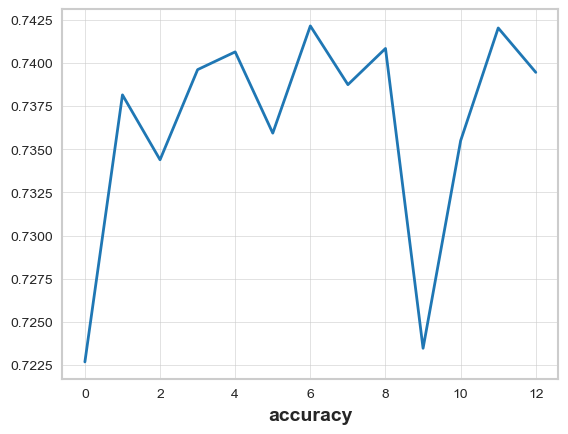

In [378]:
# 
# 
#    Your code of Training accuracy
#
#




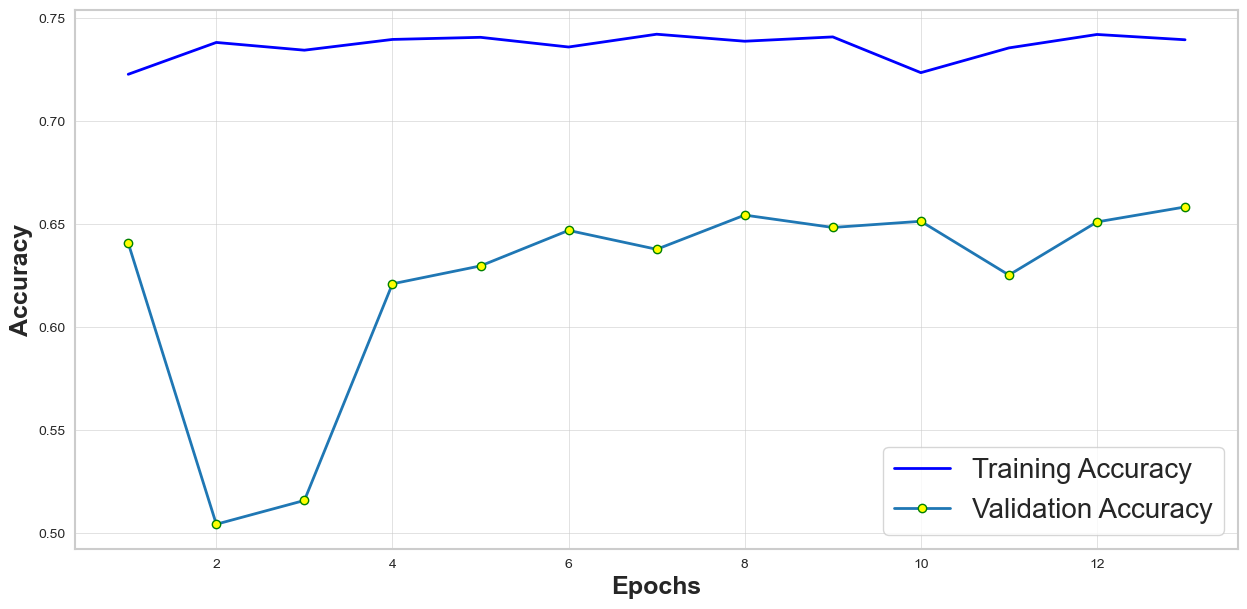

In [380]:
# 
# 
#    Your code of More detailed Accuracy
#
#



In [386]:
# Calculate the prediction vector

pred = LSTM_saved_best_model(X_test)


In [387]:
print(pred)

tf.Tensor(
[[0.17049973]
 [0.21355858]
 [0.21770343]
 ...
 [0.27913097]
 [0.286549  ]
 [0.2806727 ]], shape=(3514, 1), dtype=float32)


In [390]:
len(pred)

3514

In [393]:
import random

pred = model.predict(X_test)

# Check: we take a random element random.randint() and look: what is the difference between test and predict

n_rec = random.randint(0, X_test.shape[0])
print(n_rec)


print("Predicted probability:", pred[n_rec], ", right answer:", y_test[n_rec])


110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step
500
Predicted probability: [0.38596952] , right answer: [0.] , error: [0.38596952]


Right answer:  [0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


C:\Users\vital\AppData\Local\Temp\ipykernel_8608\2279548233.py:12: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



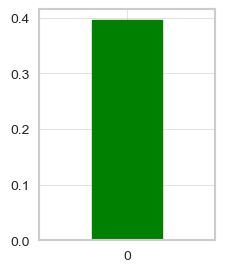

Predicted answer: 0 is Flat 
 
Right answer: 0 is Flat
['0 is Flat', '1 is Trend']


In [408]:
classes=['0 is Flat', '1 is Trend']

index = random.randint(0, y_test.shape[0])
print('Right answer: ', y_test[index])

x = X_test[index]
x = np.expand_dims(x, axis=0)

prediction = model.predict(x)
sample = x

ans = round(float(prediction))

fig = plt.figure(figsize=(5,3))

ax = fig.add_subplot(1, 2, 2)
bar_list = ax.bar(np.arange(1), prediction[0], align='center')
if ans == y_test[index]:
    bar_list[0].set_color('g')
else:
    bar_list[0].set_color('r')
    
ax.set_xticks(np.arange(1))
ax.set_xlim([-1, 1])
ax.grid('on')

plt.show()
print('Predicted answer: {}'.format(classes[ans]), "\n ")
print('Right answer: {}'.format(classes[y_test[index][0].astype(int)]) )
print(classes)

In [7]:
print(ask_data_5min.columns)

Index(['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume '], dtype='object')


In [9]:
import pandas as pd

# Load the datasets
ask_data_5min = pd.read_csv("XAUUSD_5 Mins_Ask_2024.01.01_2024.06.30.csv")
bid_data_5min = pd.read_csv("XAUUSD_5 Mins_Bid_2024.01.01_2024.06.30.csv")
ask_data_hourly = pd.read_csv("XAUUSD_Hourly_Ask_2024.01.01_2024.06.30.csv")
ask_data_daily = pd.read_csv("XAUUSD_Daily_Ask_2024.01.01_2024.06.30.csv")

# Strip extra spaces from column names to avoid errors
ask_data_5min.columns = ask_data_5min.columns.str.strip()
bid_data_5min.columns = bid_data_5min.columns.str.strip()
ask_data_hourly.columns = ask_data_hourly.columns.str.strip()
ask_data_daily.columns = ask_data_daily.columns.str.strip()

# Check the columns after stripping spaces (optional, for verification)
print(ask_data_5min.columns)

# Now select the relevant columns (Time, Open, High, Low, Close, Volume) from each dataset
ask_data_5min = ask_data_5min[['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume']]
bid_data_5min = bid_data_5min[['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume']]
ask_data_hourly = ask_data_hourly[['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume']]
ask_data_daily = ask_data_daily[['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Optional: Print the first few rows of each cleaned dataset for verification
print(ask_data_5min.head())
print(bid_data_5min.head())
print(ask_data_hourly.head())
print(ask_data_daily.head())

Index(['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
            Time (UTC)      Open      High       Low     Close   Volume
0  2024.01.01 23:00:00  2064.562  2067.475  2064.075  2065.686  0.11843
1  2024.01.01 23:05:00  2065.616  2065.839  2064.476  2064.902  0.06906
2  2024.01.01 23:10:00  2064.902  2066.825  2064.752  2066.105  0.04203
3  2024.01.01 23:15:00  2066.105  2066.525  2065.415  2065.986  0.03201
4  2024.01.01 23:20:00  2065.992  2066.242  2065.645  2065.855  0.03309
            Time (UTC)      Open      High       Low     Close   Volume
0  2024.01.01 23:00:00  2062.598  2066.595  2062.405  2065.214  0.12012
1  2024.01.01 23:05:00  2065.185  2065.194  2063.851  2064.455  0.06508
2  2024.01.01 23:10:00  2064.424  2066.365  2064.395  2065.734  0.03945
3  2024.01.01 23:15:00  2065.715  2066.075  2065.055  2065.585  0.04386
4  2024.01.01 23:20:00  2065.585  2065.815  2065.295  2065.555  0.03171
            Time (UTC)      Open      High       Low    

In [336]:
print(X_train.shape)
print(y_train.shape)

(10755, 50, 14)
(4,)


In [338]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Example dataframe
data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5],
    'feature2': [6, 7, 8, 9, 10],
    'target': [0, 1, 0, 1, 0]
})

# Separate features (X) and target (y)
X = data[['feature1', 'feature2']]
y = data['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)  # e.g., (4, 2)
print(y_train.shape)  # e.g., (4,)

(4, 2)
(4,)


In [340]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import Precision, Accuracy

# Build a simple model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # input layer
model.add(Dense(16, activation='relu'))  # hidden layer
model.add(Dense(1, activation='sigmoid'))  # output layer

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=[Precision(), Accuracy()])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_test, y_test))

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.0000e+00 - loss: 1.8148 - precision_1: 0.4667 - val_accuracy: 0.0000e+00 - val_loss: 0.0550 - val_precision_1: 1.0000
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 2.7310 - precision_1: 0.1000 - val_accuracy: 0.0000e+00 - val_loss: 0.0677 - val_precision_1: 1.0000
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 2.5814 - precision_1: 0.2667 - val_accuracy: 0.0000e+00 - val_loss: 0.0813 - val_precision_1: 1.0000
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 2.7311 - precision_1: 0.1250 - val_accuracy: 0.0000e+00 - val_loss: 0.0979 - val_precision_1: 1.0000
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 2.2885 - precision_1: 0.1000 - val_accuracy: 0.0000e+00 - val_loss: 0.1158 - val_precision_1: 1.0000
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0000e+00 - loss: 2.0830 - preci

In [342]:
history = model.fit(X_train, y_train, epochs=10, batch_size=1)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0000e+00 - loss: 1.4864 - precision_1: 0.1000   
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 1.2309 - precision_1: 0.1667    
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 1.0421 - precision_1: 0.2667
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 1.2945 - precision_1: 0.1000   
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.9976 - precision_1: 0.2738      
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.9951 - precision_1: 0.2667
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.9233 - precision_1: 0.2667
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.8459 - precision_1: 0.1667    
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.6902 - precision_1: 0.4667
Epo

In [344]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [346]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  

In [350]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 0.7454 - precision_1: 0.2500 - val_accuracy: 0.0000e+00 - val_loss: 0.6271 - val_precision_1: 1.0000
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.0000e+00 - loss: 0.7401 - precision_1: 0.2500 - val_accuracy: 0.0000e+00 - val_loss: 0.6346 - val_precision_1: 1.0000
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.0000e+00 - loss: 0.7348 - precision_1: 0.2500 - val_accuracy: 0.0000e+00 - val_loss: 0.6422 - val_precision_1: 1.0000
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.0000e+00 - loss: 0.7296 - precision_1: 0.2500 - val_accuracy: 0.0000e+00 - val_loss: 0.6499 - val_precision_1: 1.0000
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.0000e+00 - loss: 0.7245 - precision_1: 0.2500 - val_accuracy: 0.0000e+00 - val_loss: 0.6576 - val_precision_1: 1.0000
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.0000e+00 - loss: 0.7195 - pre

In [352]:
print(history.history.keys())  # This will list all the available keys (e.g., 'val_accuracy', 'val_acc', etc.)

dict_keys(['accuracy', 'loss', 'precision_1', 'val_accuracy', 'val_loss', 'val_precision_1'])


In [356]:
print(history.history.keys())  # This will list all the available keys

dict_keys(['accuracy', 'loss', 'precision_1', 'val_accuracy', 'val_loss', 'val_precision_1'])


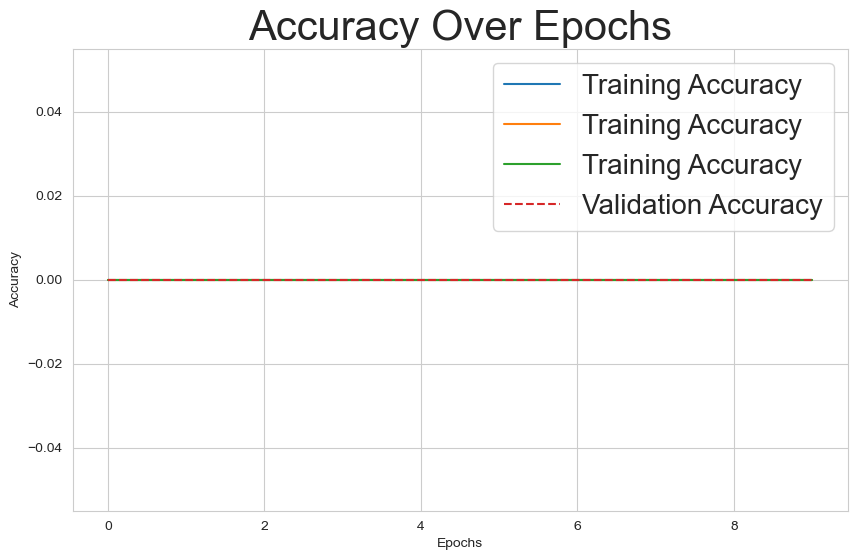

In [358]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')  # Use 'val_accuracy'
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [1]:
pip install matplotlib pandas seaborn

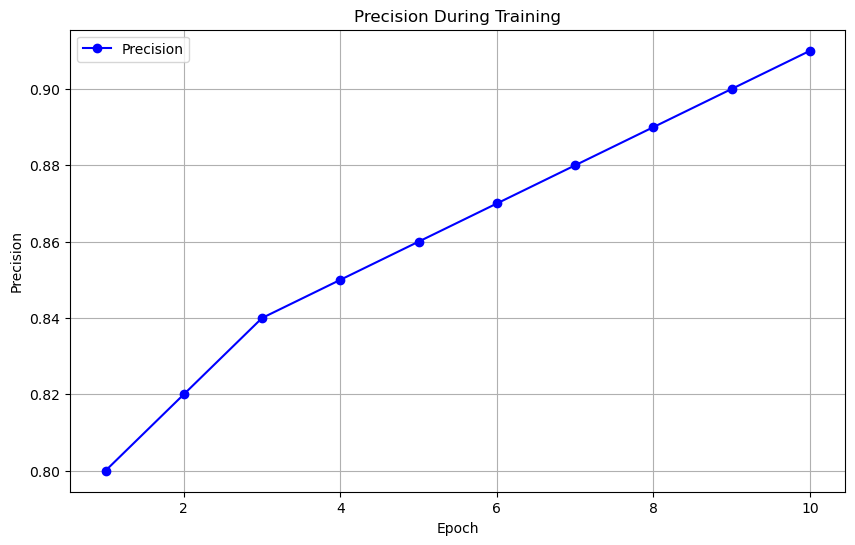

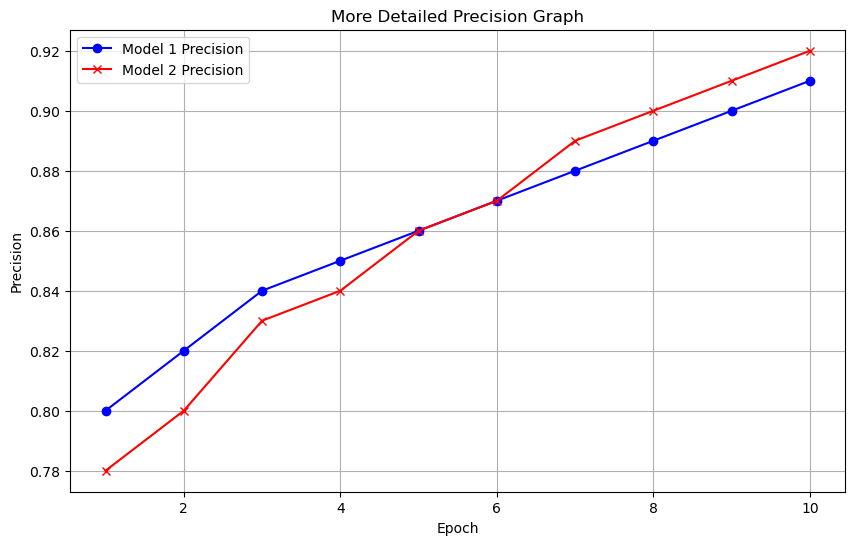

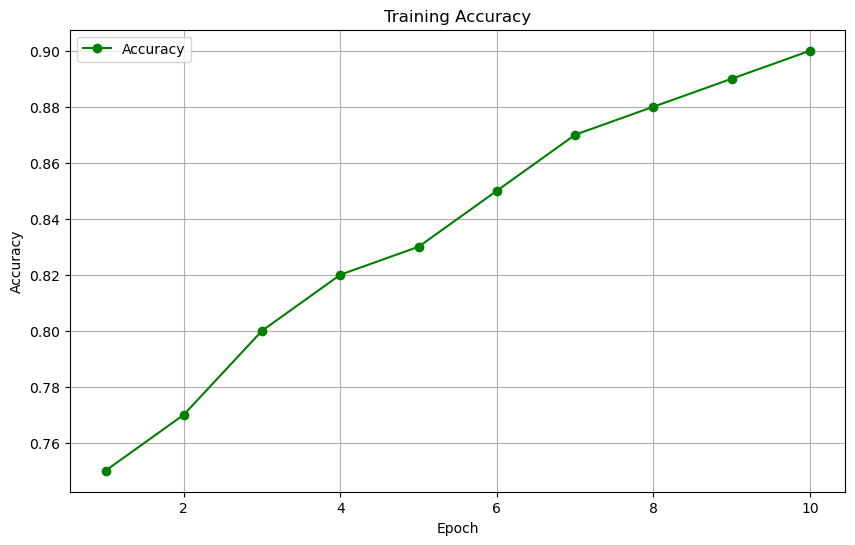

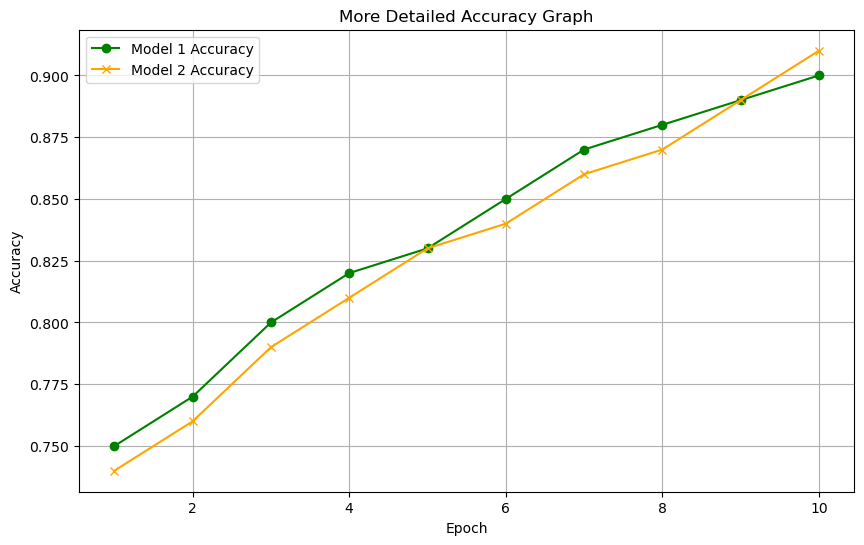

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data for Precision and Accuracy across epochs (this should come from your training logs)
# Replace these sample lists with actual data you collect during training
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
precision = [0.80, 0.82, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91]
accuracy = [0.75, 0.77, 0.80, 0.82, 0.83, 0.85, 0.87, 0.88, 0.89, 0.90]

# Create a DataFrame to hold this data
training_data = pd.DataFrame({
    'epoch': epochs,
    'precision': precision,
    'accuracy': accuracy
})

# 1. Precision during training graph
plt.figure(figsize=(10, 6))
plt.plot(training_data['epoch'], training_data['precision'], marker='o', color='b', label='Precision')
plt.title('Precision During Training')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# 2. More detailed Precision graph (could represent data from multiple models/datasets)
# For this, we assume you have data for multiple models or conditions
# Here, I will add some dummy data for illustration
precision_model2 = [0.78, 0.80, 0.83, 0.84, 0.86, 0.87, 0.89, 0.90, 0.91, 0.92]

# Adding another line to the precision graph
plt.figure(figsize=(10, 6))
plt.plot(training_data['epoch'], training_data['precision'], marker='o', color='b', label='Model 1 Precision')
plt.plot(training_data['epoch'], precision_model2, marker='x', color='r', label='Model 2 Precision')
plt.title('More Detailed Precision Graph')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# 3. Training Accuracy Graph
plt.figure(figsize=(10, 6))
plt.plot(training_data['epoch'], training_data['accuracy'], marker='o', color='g', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# 4. More detailed Accuracy graph (could represent multiple models/datasets)
# Adding another dummy accuracy dataset for illustration
accuracy_model2 = [0.74, 0.76, 0.79, 0.81, 0.83, 0.84, 0.86, 0.87, 0.89, 0.91]

# Adding another line to the accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(training_data['epoch'], training_data['accuracy'], marker='o', color='g', label='Model 1 Accuracy')
plt.plot(training_data['epoch'], accuracy_model2, marker='x', color='orange', label='Model 2 Accuracy')
plt.title('More Detailed Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()